In [1]:
#conda install -c conda-forge datapackage

In [2]:
#conda install -c conda-forge jsontableschema-panda

In [3]:
from datapackage import Package

In [4]:
import pandas as pd

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from tqdm import tqdm
tqdm.pandas() # to use in progress_apply

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [7]:
from random import sample

In [8]:
import statsmodels.api as sm

In [9]:
import us
import addfips

In [10]:
import numpy as np 

In [11]:
import os

## Get COVID-19 DataPackage and Process Files

In [12]:
package = Package('https://datahub.io/core/covid-19/datapackage.json')

In [13]:
# get list of all resources:
resources = package.descriptor['resources']
resourceList = [resources[x]['name'] for x in range(0, len(resources))]
#print(resourceList)

us_resourceList = [i for i in resourceList if ("us" in i and "csv" in i and "preview" not in i)]


print(us_resourceList)

['us_confirmed_csv', 'us_deaths_csv', 'us_simplified_csv']


In [14]:
# package.descriptor['resources']

In [15]:
us_simplified_csv = package.get_resource('us_simplified_csv').read(keyed=True)

In [16]:
type(us_simplified_csv)

list

In [17]:
df_dict = dict()
def make_pandas_dfs_from_resource(resourcenamelist):
    for resourcename in resourcenamelist:
        try:
            resource = package.get_resource(resourcename).read(keyed=True)
            df_dict[resourcename] = pd.DataFrame(resource)
            print("{name} is complete".format(name=resourcename))
        except:
            print("There was an error for {name}".format(name=resourcename))

In [18]:
make_pandas_dfs_from_resource(us_resourceList)

us_confirmed_csv is complete
us_deaths_csv is complete
us_simplified_csv is complete


In [19]:
df_dict.keys()

dict_keys(['us_confirmed_csv', 'us_deaths_csv', 'us_simplified_csv'])

In [20]:
us_simplified_df = df_dict['us_simplified_csv']

In [21]:
us_deaths_df = df_dict['us_deaths_csv']

In [22]:
us_confirmed_df = df_dict['us_confirmed_csv']

In [23]:
for i in df_dict.values():
    print(i.columns)

Index(['Admin2', 'Date', 'Case', 'Country/Region', 'Province/State'], dtype='object')
Index(['Admin2', 'Date', 'Case', 'Country/Region', 'Province/State'], dtype='object')
Index(['Date', 'Admin2', 'Province/State', 'Confirmed', 'Deaths',
       'Country/Region'],
      dtype='object')


## Shape File with Current Totals of Cases and Deaths

In [24]:
us_simplified_df

,Date,Admin2,Province/State,Confirmed,Deaths,Country/Region
0,2020-01-22,Autauga,Alabama,0,0,US
1,2020-01-23,Autauga,Alabama,0,0,US
2,2020-01-24,Autauga,Alabama,0,0,US
3,2020-01-25,Autauga,Alabama,0,0,US
4,2020-01-26,Autauga,Alabama,0,0,US
...,...,...,...,...,...,...
1078815,2020-12-05,Weston,Wyoming,419,2,US
1078816,2020-12-06,Weston,Wyoming,420,2,US
1078817,2020-12-07,Weston,Wyoming,422,2,US
1078818,2020-12-08,Weston,Wyoming,425,2,US


In [25]:
us_simplified_df['Province/State'] 

0          Alabama
1          Alabama
2          Alabama
3          Alabama
4          Alabama
            ...   
1078815    Wyoming
1078816    Wyoming
1078817    Wyoming
1078818    Wyoming
1078819    Wyoming
Name: Province/State, Length: 1078820, dtype: object

In [26]:
us_simplified_df.rename(columns={'Province/State': 'State'}, inplace=True)

In [27]:
us_simplified_df = us_simplified_df[us_simplified_df.Admin2 != 'Unassigned']

In [28]:
us_simplified_df.Date = us_simplified_df.Date.astype("datetime64")

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [29]:
us_simplified_df['Deaths_Previous'] = us_simplified_df.groupby(['Admin2','State'])['Deaths'].shift(1)

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
us_simplified_df['Confirmed_Previous'] = us_simplified_df.groupby(['Admin2','State'])['Confirmed'].shift(1)

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [31]:
us_simplified_df['Deaths_New'] = us_simplified_df.Deaths - us_simplified_df.Deaths_Previous

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
us_simplified_df['Deaths_New_+7'] = us_simplified_df.groupby(['Admin2','State'])['Deaths_New'].shift(-7)

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
us_simplified_df['Deaths_New_+14'] = us_simplified_df.groupby(['Admin2','State'])['Deaths_New'].shift(-14)

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
us_simplified_df['Deaths_New_+21'] = us_simplified_df.groupby(['Admin2','State'])['Deaths_New'].shift(-21)

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
us_simplified_df['Deaths_New_+28'] = us_simplified_df.groupby(['Admin2','State'])['Deaths_New'].shift(-28)

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
us_simplified_df['Confirmed_New'] =  us_simplified_df.Confirmed - us_simplified_df.Confirmed_Previous

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
# Add locationcol key 
us_simplified_df['locationcol'] = us_simplified_df['Admin2']+'|'+us_simplified_df['State']

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


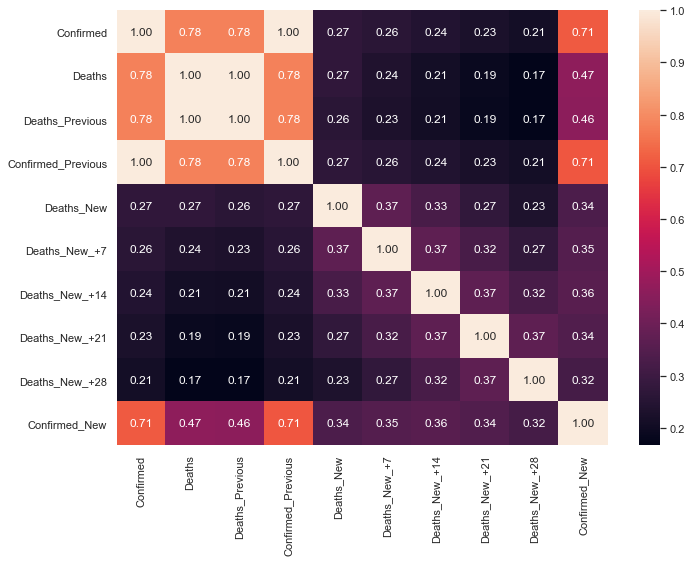

In [38]:
#Corrplot for all of the variables
sns.set(rc={'figure.figsize':(11,8)})
corr = us_simplified_df.corr()
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

In [39]:

list_all_locations = list(us_simplified_df['locationcol'].unique())

# Sample half of the locations
# sample_num = int(round(len(list_all_locations)/2, 0))
# list_locations_sampled = list_all_locations  #sample(list_all_locations, sample_num) list_all_locations

In [40]:
us_simplified_df.columns

Index(['Date', 'Admin2', 'State', 'Confirmed', 'Deaths', 'Country/Region',
       'Deaths_Previous', 'Confirmed_Previous', 'Deaths_New', 'Deaths_New_+7',
       'Deaths_New_+14', 'Deaths_New_+21', 'Deaths_New_+28', 'Confirmed_New',
       'locationcol'],
      dtype='object')

## Fix Counties - Cities Confusion

Some counties and cities have the same name. In the COVID dataset, the cities are reported with "city" but the counties have no appelation. In order for the lookup to work properly, we need to add "County" to these county-level reports. 

In [41]:
us_simplified_df_nona = us_simplified_df.dropna()

fairfax = us_simplified_df_nona[us_simplified_df_nona.Admin2.str.contains("City")]

fairfax

,Date,Admin2,State,Confirmed,Deaths,Country/Region,Deaths_Previous,Confirmed_Previous,Deaths_New,Deaths_New_+7,Deaths_New_+14,Deaths_New_+21,Deaths_New_+28,Confirmed_New,locationcol
400521,2020-01-23,Baltimore City,Maryland,0,0,US,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Baltimore City|Maryland
400522,2020-01-24,Baltimore City,Maryland,0,0,US,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Baltimore City|Maryland
400523,2020-01-25,Baltimore City,Maryland,0,0,US,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Baltimore City|Maryland
400524,2020-01-26,Baltimore City,Maryland,0,0,US,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Baltimore City|Maryland
400525,2020-01-27,Baltimore City,Maryland,0,0,US,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Baltimore City|Maryland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006758,2020-11-07,Roanoke City,Virginia,3224,47,US,47.0,3176.0,0.0,-1.0,1.0,3.0,0.0,48.0,Roanoke City|Virginia
1006759,2020-11-08,Roanoke City,Virginia,3240,47,US,47.0,3224.0,0.0,0.0,0.0,1.0,0.0,16.0,Roanoke City|Virginia
1006760,2020-11-09,Roanoke City,Virginia,3255,48,US,47.0,3240.0,1.0,1.0,0.0,0.0,0.0,15.0,Roanoke City|Virginia
1006761,2020-11-10,Roanoke City,Virginia,3313,50,US,48.0,3255.0,2.0,5.0,2.0,1.0,0.0,58.0,Roanoke City|Virginia


In [42]:
fairfax.groupby("Admin2").max()

,Date,State,Confirmed,Deaths,Country/Region,Deaths_Previous,Confirmed_Previous,Deaths_New,Deaths_New_+7,Deaths_New_+14,Deaths_New_+21,Deaths_New_+28,Confirmed_New,locationcol
Admin2,,,,,,,,,,,,,,
Baltimore City,2020-11-11,Maryland,19768,519,US,517.0,19549.0,11.0,11.0,11.0,11.0,12.0,267.0,Baltimore City|Maryland
Carson City,2020-11-11,Nevada,1005,11,US,11.0,994.0,1.0,1.0,1.0,7.0,7.0,103.0,Carson City|Nevada
Charles City,2020-11-11,Virginia,113,5,US,5.0,112.0,2.0,2.0,2.0,2.0,2.0,4.0,Charles City|Virginia
Fairfax City,2020-11-11,Virginia,178,8,US,8.0,175.0,2.0,2.0,2.0,2.0,2.0,10.0,Fairfax City|Virginia
Franklin City,2020-11-11,Virginia,521,14,US,14.0,520.0,2.0,2.0,2.0,2.0,2.0,22.0,Franklin City|Virginia
James City,2020-11-11,Virginia,1020,22,US,22.0,1018.0,10.0,10.0,10.0,10.0,10.0,35.0,James City|Virginia
Kansas City,2020-11-11,Missouri,17845,241,US,236.0,17564.0,17.0,17.0,17.0,17.0,17.0,835.0,Kansas City|Missouri
Richmond City,2020-11-11,Virginia,5840,78,US,78.0,5799.0,10.0,10.0,10.0,10.0,10.0,81.0,Richmond City|Virginia
Roanoke City,2020-11-11,Virginia,3343,50,US,50.0,3313.0,7.0,7.0,7.0,7.0,7.0,68.0,Roanoke City|Virginia


In [43]:
fairfax.locationcol = fairfax.Admin2+'|'+fairfax.State

cities_list = list(fairfax.locationcol.unique())

counties_with_citynames_list = [i.replace(' City','') for i in cities_list]

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [44]:
counties_with_citynames_list

['Baltimore|Maryland',
 'Kansas|Missouri',
 'St. Louis|Missouri',
 'Carson|Nevada',
 'Charles|Virginia',
 'Fairfax|Virginia',
 'Franklin|Virginia',
 'James|Virginia',
 'Richmond|Virginia',
 'Roanoke|Virginia']

In [45]:
no_county_issues = us_simplified_df[(us_simplified_df.Admin2+'|'+us_simplified_df.State).isin(counties_with_citynames_list) == False]

In [46]:
county_issues = us_simplified_df[(us_simplified_df.Admin2+'|'+us_simplified_df.State).isin(counties_with_citynames_list)]

In [47]:
county_issues.Admin2 = county_issues.Admin2+' County'

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [48]:
county_issues.Admin2.unique()

array(['Baltimore County', 'St. Louis County', 'Fairfax County',
       'Franklin County', 'Richmond County', 'Roanoke County'],
      dtype=object)

In [49]:
us_simplified_df_countyfixed = pd.concat([county_issues,no_county_issues],ignore_index=True)

In [50]:
us_simplified_df_countyfixed.locationcol = us_simplified_df_countyfixed.Admin2+'|'+us_simplified_df_countyfixed.State

In [51]:
us_simplified_df_countyfixed.shape[0]/us_simplified_df.shape[0]

1.0

In [52]:
us_simplified_df = us_simplified_df_countyfixed

## County Level - Add the Rolling Averages and Recombine

In [53]:
list_frames = []
for i in tqdm(list_all_locations):
    frame = us_simplified_df[us_simplified_df.locationcol == i]
    frame['Confirmed_New_RollingAvg'] = frame.rolling(7, min_periods=7, center=False, on="Date")['Confirmed_New'].mean()
    frame['Deaths_New_RollingAvg'] = frame.rolling(7, min_periods=7, center=False, on="Date")['Deaths_New'].mean()
    frame['Deaths_New_+7_RollingAvg'] = frame.rolling(7, min_periods=7, center=False, on="Date")['Deaths_New_+7'].mean()
    frame['Deaths_New_+14_RollingAvg'] = frame.rolling(7, min_periods=7, center=False, on="Date")['Deaths_New_+14'].mean()
    frame['Deaths_New_+21_RollingAvg'] = frame.rolling(7, min_periods=7, center=False, on="Date")['Deaths_New_+21'].mean()
    frame['Deaths_New_+28_RollingAvg'] = frame.rolling(7, min_periods=7, center=False, on="Date")['Deaths_New_+28'].mean()
    list_frames.append(frame)

  0%|          | 0/3283 [00:00<?, ?it/s]/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [54]:
large_frame_df = pd.concat(list_frames)

In [55]:
# Take a look at one county
yuma = large_frame_df[large_frame_df['locationcol'] == 'Yuma|Arizona']

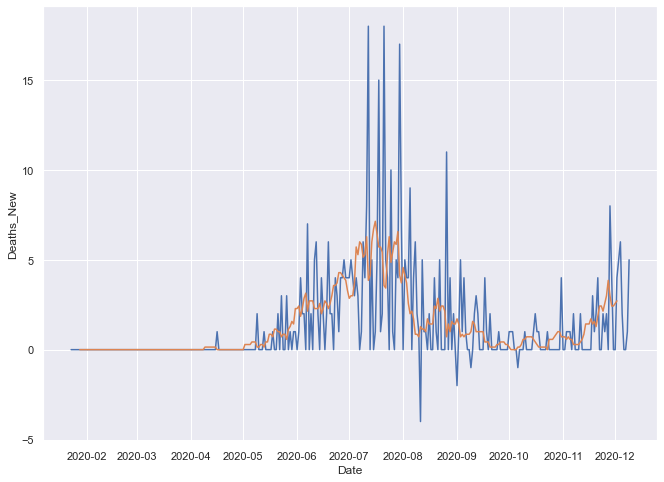

In [56]:
plot1 = sns.lineplot(x="Date", y="Deaths_New", data=yuma)
plt1 = sns.lineplot(x="Date", y="Deaths_New_+7_RollingAvg", data=yuma)

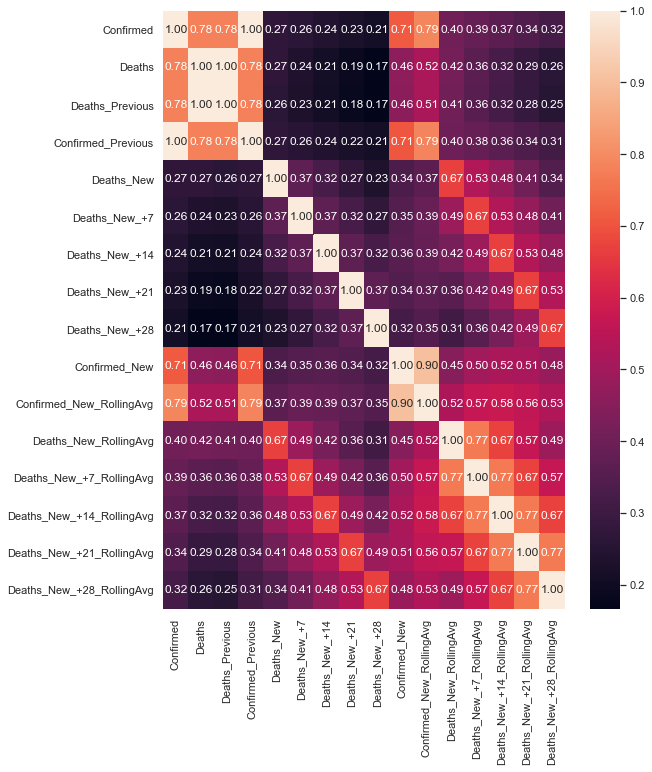

In [57]:
#Corrplot
sns.set(rc={'figure.figsize':(9,11)})
corr = large_frame_df.corr()
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

## Mapping FIPS Codes to the COVID Dataset using addfips

In [58]:
large_frame_df.columns
# No FIPS codes natively included in this dataset, so I had to construct a mapping process 

Index(['Date', 'Admin2', 'State', 'Confirmed', 'Deaths', 'Country/Region',
       'Deaths_Previous', 'Confirmed_Previous', 'Deaths_New', 'Deaths_New_+7',
       'Deaths_New_+14', 'Deaths_New_+21', 'Deaths_New_+28', 'Confirmed_New',
       'locationcol', 'Confirmed_New_RollingAvg', 'Deaths_New_RollingAvg',
       'Deaths_New_+7_RollingAvg', 'Deaths_New_+14_RollingAvg',
       'Deaths_New_+21_RollingAvg', 'Deaths_New_+28_RollingAvg'],
      dtype='object')

In [59]:
def lookup_location(locationstring):
    af = addfips.AddFIPS()
    try:
        namelist = locationstring.split('|')
        statename = namelist[1]
        countyname = namelist[0]
        fipscode = af.get_county_fips(countyname, state=statename)
        return fipscode
    except:
        return np.NaN

In [60]:
tqdm.pandas()

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [61]:
unique_counties = pd.DataFrame(large_frame_df.locationcol.unique(), columns = ['locationcol'])

In [62]:
unique_counties['County_FIPS'] = unique_counties['locationcol'].progress_apply(lookup_location)

100%|██████████| 3276/3276 [01:09<00:00, 46.87it/s]


## Visualizing County-Level Data for COVID

In [63]:
large_frame_df = large_frame_df.merge(unique_counties, on="locationcol", how="left")

In [64]:
large_frame_df_mapping_counties = large_frame_df.groupby(['County_FIPS','State'])['Deaths'].max().reset_index()

In [65]:
large_frame_df_mapping_counties.head(10)

,County_FIPS,State,Deaths
0,01001,Alabama,42
1,01003,Alabama,141
2,01005,Alabama,30
3,01007,Alabama,39
4,01009,Alabama,47
5,01011,Alabama,20
6,01013,Alabama,42
7,01015,Alabama,127
8,01017,Alabama,55
9,01019,Alabama,24


## Roll Up to State Level

In [66]:
us_simplified_df = us_simplified_df.groupby(['State','Date']).sum().reset_index()

In [67]:
list_frames = []
for i in tqdm(list(us_simplified_df.State.unique())):
    frame = us_simplified_df[us_simplified_df.State == i]
    frame['Confirmed_New_RollingAvg'] = frame.rolling(7, min_periods=7, center=True, on="Date")['Confirmed_New'].mean()
    frame['Deaths_New_+7_RollingAvg'] = frame.rolling(7, min_periods=7, center=True, on="Date")['Deaths_New_+7'].mean()
    frame['Deaths_New_+14_RollingAvg'] = frame.rolling(7, min_periods=7, center=True, on="Date")['Deaths_New_+14'].mean()
    frame['Deaths_New_+21_RollingAvg'] = frame.rolling(7, min_periods=7, center=True, on="Date")['Deaths_New_+21'].mean()
    frame['Deaths_New_+28_RollingAvg'] = frame.rolling(7, min_periods=7, center=True, on="Date")['Deaths_New_+28'].mean()
    list_frames.append(frame)

  0%|          | 0/58 [00:00<?, ?it/s]/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [68]:
statelevel_large_df = pd.concat(list_frames)

## Get State Region Names from State

In [69]:
def normalize_name_from_state(x):
    state = us.states.lookup(x)
    normalized_state_name = state.name
    return normalized_state_name

In [70]:
states_regions = pd.read_csv('https://raw.githubusercontent.com/cphalpert/census-regions/master/us%20census%20bureau%20regions%20and%20divisions.csv')

In [71]:
#states_regions

In [72]:
states_regions_merged = statelevel_large_df.merge(states_regions, on="State", how="left")

In [73]:
# some of these don't have regions
states_regions_merged[states_regions_merged.Region.isna() == True]['State'].unique()
states_regions_merged.Region.fillna('Other Region',inplace=True)

In [74]:
states_regions_merged.Confirmed_New_RollingAvg.isna().value_counts()

False    18386
True       348
Name: Confirmed_New_RollingAvg, dtype: int64

In [75]:
states_regions_merged_nona = states_regions_merged.dropna()

## County-Level Frame with Divisions Added

In [80]:
large_frame_df_divisions = large_frame_df.merge(states_regions, on="State", how="left")

In [81]:
large_frame_df_divisions.head(5)

,Date,Admin2,State,Confirmed,Deaths,Country/Region,Deaths_Previous,Confirmed_Previous,Deaths_New,Deaths_New_+7,...,Confirmed_New_RollingAvg,Deaths_New_RollingAvg,Deaths_New_+7_RollingAvg,Deaths_New_+14_RollingAvg,Deaths_New_+21_RollingAvg,Deaths_New_+28_RollingAvg,County_FIPS,State Code,Region,Division
0,2020-01-22,Autauga,Alabama,0,0,US,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,01001,AL,South,East South Central
1,2020-01-23,Autauga,Alabama,0,0,US,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,01001,AL,South,East South Central
2,2020-01-24,Autauga,Alabama,0,0,US,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,01001,AL,South,East South Central
3,2020-01-25,Autauga,Alabama,0,0,US,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,01001,AL,South,East South Central
4,2020-01-26,Autauga,Alabama,0,0,US,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,01001,AL,South,East South Central


## Export Full Dataset to File and Save Sample to FIle

In [82]:
import os
os.chdir(r'/Users/philip.ballentine/Documents/hia_covid_repo/hia_covid_data_assets/')
path = str(os.getcwd())
filename = "covid_dataset_full.csv"
large_frame_df_divisions.to_csv(filename)
print("{filename} has been created in {path}".format(filename=filename, path=path))

covid_dataset_full.csv has been created in /Users/philip.ballentine/Documents/hia_covid_repo/hia_covid_data_assets


In [83]:
#create sample
large_frame_df_divisions_sample = large_frame_df_divisions.sample(frac=.1)

filename = "covid_dataset_sample.csv"
large_frame_df_divisions_sample.to_csv(filename)
print("{filename} has been created in {path}".format(filename=filename, path=path))

covid_dataset_sample.csv has been created in /Users/philip.ballentine/Documents/hia_covid_repo/hia_covid_data_assets


In [84]:
df = large_frame_df_divisions

In [86]:
df_max = df[df.Date == df.Date.max()]

In [90]:
df_max.Deaths.describe()

count    3276.000000
mean       86.888278
std       366.169703
min         0.000000
25%         6.000000
50%        18.000000
75%        51.000000
max      8075.000000
Name: Deaths, dtype: float64